# Lab4: Constrained optimization: equality and inequality constraints

**Carla Sendra Balcells**\
**Roxane Le Tensorer**\
**Rachel Trimble**

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from QPGC import *
import tqdm

The problem we want to solve is the following one:

Minimize $f(\alpha)=\sum_{i=1}^{m} -\alpha_i + \dfrac{1}{2} \alpha^T(YX^T XY)\alpha  $<br>
Subject to $\sum_{i=1}^{m} y_i \alpha_i = 0 \;\;\;,\;\;\;0 \leq \alpha_i \leq K $<br>

But we will try to convert it to this notation:

Minimize $f(x)=\dfrac{1}{2} x^T G x + g^T x $<br>
Subject to $A^T x=b \;\;\;,\;\;\;C^T x \geq d$<br>

So, we could define:

$G = Y X^T XY$\
$x = \alpha$\
$g^T = -[1,1,...n]$\
$A = y$\
$b = 0$\
$C = Id$\
$d = K$

$G\in R^{nxn}$,
$x\in R^{n}$,
$g\in R^{n}$,
$A\in R^{nxp}$,
$C\in R^{nxm}$,
$b\in R^{p}$,
$d\in R^{m}$, 
$Y\in R^{nxn}$,
$y\in R^{n}$,
$X\in R^{mxn}$,
$\alpha \in R^{n}$,
$K \in R^{m}$

where n are the number of samples (n=200) and m the number of constraints (m=200x2), p=1. 

First of all, we create a function able to generate the two datasets based on the given means and covariances. There are two different situation: if the datasets are separable, it means that it is possible to find an hyperplane that will strictly divide the two sets, meaning that absolutely no value will be in the wrong category. On the contrary, if the datasets are non separable, no hyperplane will be able to strictly divide the two sets. It means that, in this second situation, the hyperplane should try to minimize the errors of classification. <br>
This is the reason why the generate_dataset algorithm takes two parameters which are the separable or not aspect of the datasets, and also the number of values in each dataset. 

In [86]:
def generate_dataset(N, separable):
    m1 = [0, 0]
    s1 = [[1, -0.9], [-0.9, 1]]
    s2 = [[1, 0], [0, 1]]
    if separable:
        m2 = [3, 6]
    else:
        m2 = [1, 2]
    cluster_1 = np.random.multivariate_normal(m1, s1, N)
    cluster_2 = np.random.multivariate_normal(m2, s2, N)
    X = np.concatenate([cluster_1, cluster_2]).T
    Y = np.diag(np.concatenate([np.ones(cluster_1.shape[0]), -np.ones(cluster_2.shape[0])]))
    return X, Y, cluster_1, cluster_2

We create now an algorithm ploting the two datasets, in order to visualize the difference between separable datasets and non-separable datasets.

In [87]:
def plot_both_clusters(N):
    _, _, c1s, c2s = generate_dataset(N,True)
    _, _, c1n, c2n = generate_dataset(N, separable=False)

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(121)
    ax.plot(c1s[:, 0], c1s[:, 1], marker='o', linestyle='None', alpha=0.7)
    ax.plot(c2s[:, 0], c2s[:, 1], marker='o',linestyle='None', alpha=0.7)
    ax.set_title("Separable problem")

    ax = fig.add_subplot(122)
    ax.plot(c1n[:, 0], c1n[:, 1], marker='o', linestyle='None', alpha=0.7)
    ax.plot(c2n[:, 0], c2n[:, 1], marker='o',linestyle='None', alpha=0.7)
    ax.set_title("Non-separable problem")


    plt.show()

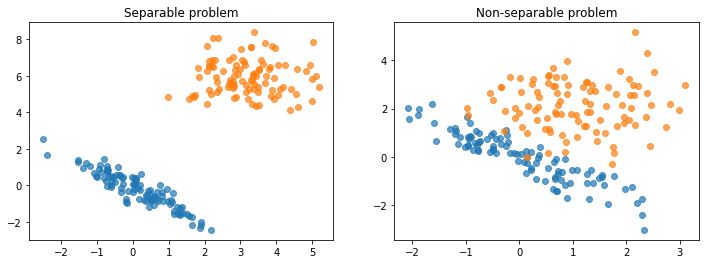

In [88]:
plot_both_clusters(100)

As we can easily see in this example, in the first case, we can visualize a line sharing the space in order to set the blue points in one side and the orange points in the other side. However, this is not possible in the second case, because points are much closer and some of them mix and overlap.  

## Separable Dataset

### 1. Simple case (N=2)

In [215]:
N=2
X, Y, cluster1, cluster2 = generate_dataset(N,True)
X.shape, Y.shape, cluster1.shape, cluster2.shape

((2, 4), (4, 4), (2, 2), (2, 2))

As exlained at the begining of the lab, we will use the notation: <br>
Minimize $f(x)=\dfrac{1}{2} x^T G x + g^T x $<br>
Subject to $A^T x=b \;\;\;,\;\;\;C^T x \geq d$<br>
So we have to determine the value of each parameter. For this, we define a function "param" to convert X, Y into the desired notation in order to compile the dual problem.

I changed a few things in the function called param(), but i don't know if the result is great so i didn't remove the initial function, i just added another one called "param2". It is supposed to solve the problem of the non-separable dataset. 

In [241]:
def param(X, Y, K=1):
    n = X.shape[1]
    m = 2*n
    
    G = np.dot(np.dot(np.dot(Y,X.T),X),Y)
    g = -np.ones(n)
    A = np.expand_dims(np.diag(Y), axis=0).T
    b = np.zeros(1)
    C = np.eye(n, m)
    d = np.zeros(m)*K
    
    return G, g, A, C, b, d


def param2(X, Y, K=1):
    n = X.shape[1]
    
    G = np.dot(np.dot(np.dot(Y,X.T),X),Y)
    g = -np.ones(n)
    A = np.expand_dims(np.diag(Y), axis=0).T
    b = np.zeros(1)
    
    C1 = np.eye(n)
    C2 = -np.eye(n)
    d1 = np.zeros(n)
    d2 = -np.ones(n)*K
    C = np.concatenate((C1,C2), axis=1)
    d = np.concatenate((d1,d2), axis=0)
    
    return G, g, A, C, b, d

In [249]:
G, g, A, C, b, d = param(X, Y, K=1)
G.shape, g.shape, A.shape, C.shape, b.shape, d.shape

((40, 40), (40,), (40, 1), (40, 80), (1,), (80,))

Once the dual problem has been solved and the optimal value of $\alpha$ is acquired, the parameters $w$ and $b$ can be solved utilizing the below formulas: <br>

$w = \sum_{i=1}^m\alpha_iy_ix_i$\
$b = \frac{1}{y_j}-w^Tx_j$

where $\alpha \in R^2$ and $b\in R^1$

Moreover, $x_j$ and $y_j$ are the ones with the $\alpha$ that gets a higher minimization at $f(\alpha)$, for this reason $\alpha_j$ should be the one with a highest value. 

In [218]:
def sol(X, Y, alpha):
    w = np.dot(X,np.diag(alpha*Y))
    j = np.argmax(alpha)
    b = Y[j,j]-np.dot(w,X[:,j])
    return w,b

In [280]:
def plot_svm(plot_information): 
    nb_figures = len(plot_information)
    fig = plt.figure(figsize=(4*nb_figures, 4))
    
    for figure in range(0,nb_figures):
        cluster_1,cluster_2, w, b = plot_information[figure]
    
        x_plot,y_plot = np.meshgrid(np.linspace(-5,7,100),np.linspace(-4,10,100))
        mesh = np.c_[x_plot.ravel(),y_plot.ravel()]     
        z = np.dot(mesh,w)+b

        ax = fig.add_subplot(100+nb_figures*10+figure+1)
        ax.plot(cluster_1[:,0],cluster_1[:,1],color='c', marker='o', linestyle='None', alpha=0.7)
        ax.plot(cluster_2[:,0],cluster_2[:,1],color='orange', marker='o',linestyle='None', alpha=0.7)
        ax.contour(x_plot,y_plot,z.reshape((100,100)),[-1.,0.,1.])

    plt.show()

We now run the algorithm, setting the parameter K as 1.

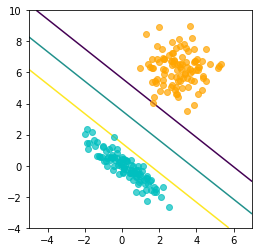

w:[-0.45458747 -0.47860537] b:1.6939147898425166


In [341]:
K=1

G, g, A, C, b, d = param2(X, Y, K)
alpha = QPGenericConstraints(G, g, A, C, b, d)

w, b = sol(X, Y, alpha)

plot_information = np.array([[cluster1,cluster2,w,b]])

plot_svm(plot_information)
print('w:'+str(w)+' b:'+str(b))

We observe that there is a critical subset of data points. These are called Support Vectors. If any of those points disappear the boundary changes. The "maximum-margin hyperplane" formed from these support vectors divides the clusters for which $y_i=1$ from the group of points for which $y_i=-1$, which is defined so that the distance between the hyperplane and the nearest point from either group is maximized. 

The algorithm seems to have been succesful at separating the separable data into two distinct groups.

We can now try with a higher number N of points.

### 2. Simple case (N=100)

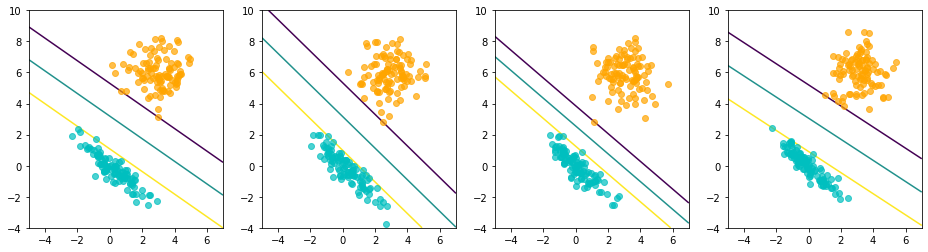

In [342]:
N=100

info = []

for i in range(0,4):
    X, Y, cluster1, cluster2 = generate_dataset(N,True)
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    
    newInfo = [cluster1,cluster2,w,b]
    info.append(newInfo)

plot_information = np.array(info)

plot_svm(plot_information)
#print('w:'+str(w)+' b:'+str(b))

The algorithm is successful at dividing the dataset into two distinct groups. 

The parameter K is part of the constraint applied to the minimization process, and we will study now the impact of its evolution on the accuracy of the algorithm. We will try, for instance, $K = 10^6$ and $K = 10^{12}$.

### 3. Testing different values for $K$

K=10^6


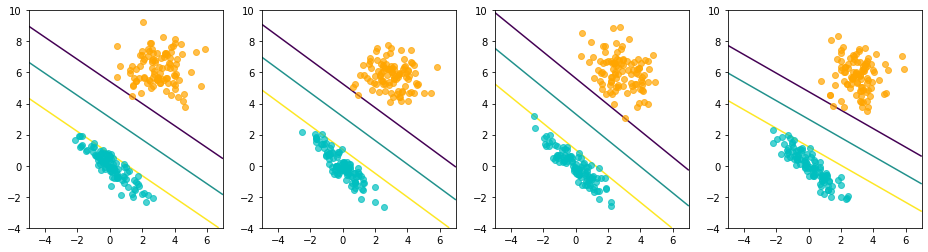

K=10^12


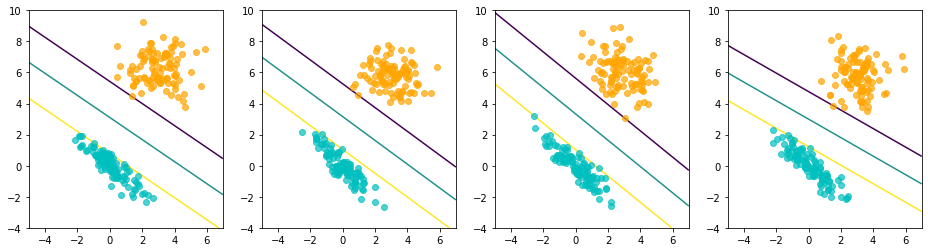

In [356]:
N=100
info = []
info2 = []
for i in range(0,4):
    X, Y, cluster1, cluster2 = generate_dataset(N,True)
    
    K=10**6
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info.append(newInfo)
    
    K=10**12
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info2.append(newInfo)

print("K=10^6")
plot_information = np.array(info)
plot_svm(plot_information)

print("K=10^12")
plot_information = np.array(info2)
plot_svm(plot_information)

The algorithm works for the larger values of K, this is because we are in the separable case, and since $\alpha$ is not bounded by $K$ in the separable case the result is consistent for all values of $K$

## Non Separable Dataset

We can now try the same experimental values, but with non-separable datasets. 

The principle here is that each point categorized in the wrong group will have a penalty, depending on how far the point is from the margin. Then, the calculus will introduce a new variable which is $\xi$, representing the penalty of each point which is not in the right category. The goal is now to minimize the sum of all the penalties.

first method


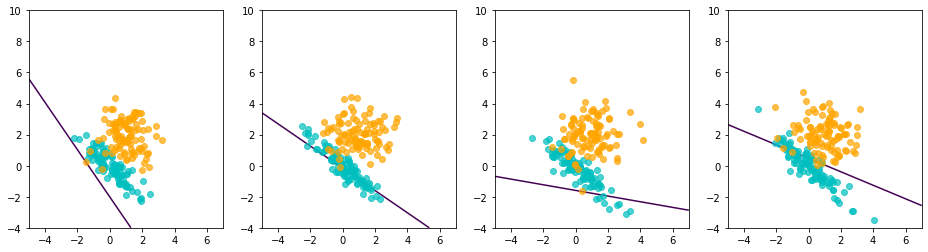

second method


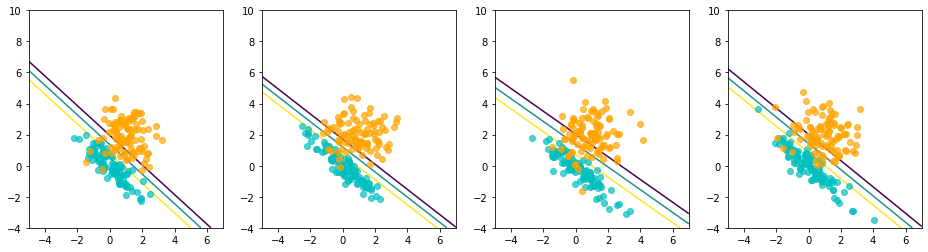

In [359]:
N=100
K=1
info = []
info2 = []
for i in range(0,4):
    X, Y, cluster1, cluster2 = generate_dataset(N,False)
    
    G, g, A, C, b, d = param(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info.append(newInfo)
    
    G, g, A, C, b, d = param2(X, Y, K)
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    w, b = sol(X, Y, alpha)
    newInfo = [cluster1,cluster2,w,b]
    info2.append(newInfo)

print("first method")
plot_information = np.array(info)
plot_svm(plot_information)

print("second method")
plot_information = np.array(info2)
plot_svm(plot_information)

For the moment, i just tried with K = 1. The second method is the result of the other way to calculate the parameters (the function param2). It seems better than the first one, but i don't know if it is correct since it's a bit confused...

Most of the time, it seems to work, but not always actually. Maybe it's normal, because i guess that this method is not supposed to be perfect (otherwise, he wouldn't ask us to compare it with the next lab i guess ^^)